In [1]:
import sys
import os
import yaml
from itertools import product
from collections import defaultdict
from tqdm.auto import tqdm

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from scipy import interpolate, optimize
from sklearn.linear_model import LinearRegression

import pandas as pd
from sympy import parse_expr, lambdify, latex, Symbol

from pymongo import MongoClient
import pymongo

from seml.database import get_collection
from seml.evaluation import parse_jsonpickle

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

In [3]:
RMSE_loss_fn = lambda x, y: np.sqrt(np.mean(np.power(x-y, 2)))
relative_RMSE_loss_fn = lambda x, y: RMSE_loss_fn(x, y) / np.sqrt(np.mean(np.power(y, 2)))

In [4]:
target = lambda x: np.exp(x)

In [5]:
powers1d = [1, 2, 3, 5, 7]
n_interpolation_points1d = [int(1.5**i) for i in range(6, 37)]
interpolation_losses1d = defaultdict(list)

for p in tqdm(powers1d):
    for n in n_interpolation_points1d:
        xs = np.linspace(-1, 1, n, dtype=np.float64)
        ys = target(xs)
        f = interpolate.interp1d(xs, ys, kind=p)
        xs_dense = np.linspace(-0.9, 0.9, 2000,  dtype=np.float64)
        interpolation_losses1d[p].append(relative_RMSE_loss_fn(f(xs_dense), target(xs_dense)))


  0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
powers2d = ['linear', 'cubic', 'quintic']
n_interpolation_points2d = [int(1.5**i) for i in range(9, 36)]
#                             2**(2*i) for i in range(3, 11)]

In [7]:
interpolation_losses2d = defaultdict(list)
for p in tqdm(powers2d):
    for n in n_interpolation_points2d:
        sqrt_n = int(n ** 0.5)
        x = np.linspace(-1, 1, sqrt_n, dtype=np.float64)
        y = np.linspace(-1, 1, sqrt_n, dtype=np.float64)
        xx, yy = np.meshgrid(x, y)
        zz = np.exp(xx * yy)
        f = interpolate.interp2d(x, y, zz, kind=p)
        x_test = np.linspace(-0.8, 0.8, 121)
        y_test = np.linspace(-0.8, 0.8, 121)
        xx_test, yy_test = np.meshgrid(x_test, y_test)
        zz_test = np.exp(xx_test * yy_test)
        zz_test_preds = f(x_test, y_test)
        interpolation_losses2d[p].append(relative_RMSE_loss_fn(zz_test_preds, zz_test))


  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

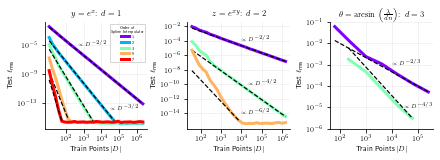

In [20]:
plt.figure(figsize=(6, 2.1))

ax = plt.subplot(1, 3, 1)
ranges = {
    1: (2e1, 1e6),
    2: (2e1, 1e4),
    3: (4e1, 1e3),
    5: (2e1, 1e2),
    7: (2e1, 5e1)
}

last_power_law_index = {
    1: -1,
    2: 21,
    3: 14,
    5: 6,
    7: 4
}

text_position = {
    1: (5e2, 1e-5),
    2: (3e4, 1.5e-14),
    3: (3e3, 1e-14),
#     5: (1e4, 1e-14)
}

colors = plt.cm.rainbow(np.linspace(0.0, 1.0, len(powers1d)))
for i, p in enumerate(powers1d):
    plt.plot(n_interpolation_points1d, interpolation_losses1d[p], label=p, 
             color=colors[i],
             linewidth=3)
#     xs = []
#     ys = []
#     for j in range(len(n_interpolation_points1d)):
#         if n_interpolation_points1d[j] > ranges[p][0] and n_interpolation_points1d[j] < ranges[p][1]:
#             xs.append(n_interpolation_points1d[j])
#             ys.append(interpolation_losses1d[p][j])
#     xs = np.log(xs).reshape((-1, 1))
#     ys = np.log(ys)
#     reg = LinearRegression().fit(xs, ys)
#     slope = reg.coef_.item()
#     if p in [1, 2, 3, 4]:
#         plt.text(n_interpolation_points1d[5], interpolation_losses1d[p][5]*1.8, "$\propto D^{" + "{:.3f}".format(round(slope, 3)) + "}$", fontsize=4, color=colors[i])
    if p < 10:
        xs = [n_interpolation_points1d[0], n_interpolation_points1d[last_power_law_index[p]]]
        C = interpolation_losses1d[p][last_power_law_index[p]] / np.power(n_interpolation_points1d[last_power_law_index[p]], -(p+1) / 1)
        ys = C * np.power(xs, -(p+1) / 1)
        plt.plot(xs, ys, '--', color='black', linewidth=1.2, alpha=1.0)
        if p < 3:
            plt.text(text_position[p][0], 
                 text_position[p][1], 
                 "$\propto D^{-" + "{}/{}".format(p+1, 2) + "}$", 
                 fontsize=5, 
                 color='black')
    
    plt.tick_params(axis='x', which='major')
    # Hide the right and top spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.grid(True, which="both", linestyle='-', linewidth=0.5, alpha=0.3)
    
#     print(slope)
#     if p in [0, 1, 2]:
#         rise = np.log(interpolation_losses1d[p][10]) - np.log(interpolation_losses1d[p][0])
#         run = np.log(n_interpolation_points1d[10]) - np.log(n_interpolation_points1d[0])
#         plt.text(n_interpolation_points1d[5], 
#                  interpolation_losses1d[p][5]*1.8,
#                  "{:.2f}".format(rise/run))
        

plt.title("$y = e^x$: $d=1$", fontsize=8)
plt.xlabel(r"Train Points $|D|$", fontsize=7)
plt.ylabel(r"Test $\ell_\text{rms}$", fontsize=7)
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xticks([100, 1000, 10000, 100000, 1000000])
legend = plt.legend(title='Order of\n Spline Interpolator', loc='upper right', prop={'size': 4})
plt.setp(legend.get_title(), multialignment='center', fontsize=4)







ax = plt.subplot(1, 3, 2)
# ranges = {
#     'linear': (2e1, 1e6),
#     'cubic': (3e2, 1e6),
#     'quintic': (2e1, 5e3),
# }
powers2d_to_int = {
    'linear': 1,
    'cubic': 3,
    'quintic': 5
}

last_power_law_index = {
    'linear': -1,
    'cubic': -1,
    'quintic': 13
}

text_position = {
    1: (1e4, 1e-4),
    3: (2e4, 1e-10),
    5: (1e4, 1e-14)
}

# colors = plt.cm.viridis(np.linspace(0.0, 1.0, len(powers2d)))
for i, p in enumerate(powers2d):
    plt.plot(n_interpolation_points2d, interpolation_losses2d[p], 
             color=colors[powers1d.index(powers2d_to_int[p])],
             linewidth=3)
    xs = []
    ys = []
#     for j in range(len(n_interpolation_points2d)):
#         if n_interpolation_points2d[j] > ranges[p][0] and n_interpolation_points2d[j] < ranges[p][1]:
#             xs.append(n_interpolation_points2d[j])
#             ys.append(interpolation_losses2d[p][j])
#     xs = np.log(xs).reshape((-1, 1))
#     ys = np.log(ys)
#     reg = LinearRegression().fit(xs, ys)
#     slope = reg.coef_.item()
#     if p in ['linear', 'cubic']:
#         plt.text(n_interpolation_points2d[3], interpolation_losses2d[p][3]*1.8, "$\propto D^{" + "{:.3f}".format(round(slope, 3)) + "}$", fontsize=4, color=colors[i])
        
    xs = [n_interpolation_points2d[0], n_interpolation_points2d[last_power_law_index[p]]]
    C = interpolation_losses2d[p][last_power_law_index[p]] / np.power(n_interpolation_points2d[last_power_law_index[p]], -(powers2d_to_int[p]+1) / 2)
    ys = C * np.power(xs, -(powers2d_to_int[p]+1) / 2)
    plt.plot(xs, ys, '--', color='black', linewidth=1.2, alpha=1.0)
    plt.text(text_position[powers2d_to_int[p]][0], 
             text_position[powers2d_to_int[p]][1], 
             "$\propto D^{-" + "{}/{}".format(powers2d_to_int[p]+1, 2) + "}$", 
             fontsize=5, 
             color='black')
    
    plt.tick_params(axis='x', which='major')
    # Hide the right and top spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.grid(True, which="both", linestyle='-', linewidth=0.5, alpha=0.3)
    
#     print(slope)
#     if p in [0, 1, 2]:
#         rise = np.log(interpolation_losses2d[p][10]) - np.log(interpolation_losses2d[p][0])
#         run = np.log(n_interpolation_points2d[10]) - np.log(n_interpolation_points2d[0])
#         plt.text(n_interpolation_points2d[5], 
#                  interpolation_losses2d[p][5]*1.8,
#                  "{:.2f}".format(rise/run))


plt.title("$z = e^{xy}$: $d=2$", fontsize=8)
plt.xlabel(r"Train Points $|D|$", fontsize=7)
plt.ylabel(r"Test $\ell_\text{rms}$", fontsize=7)
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xticks([100, 1000, 10000, 100000, 1000000])
plt.yticks([1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12, 1e-14])
# l = plt.legend(title='Interpolator', loc='upper right', prop={'size': 4})
# plt.setp(l.get_title(), multialignment='center', fontsize=4)








ax = plt.subplot(1, 3, 3)
cubic_collection = get_collection('feynman-cubic-1')
simplex_collection = get_collection('feynman-simplex-3ds-2')

symbol_names = {
    Symbol('Ef'): 'E_f',
    Symbol('E_den'): 'E_{\text{den}}',
    Symbol('lambd'): '\lambda',
    Symbol('kb'): 'k_b'
}

fields = ['config']
query = {
    'status': 'COMPLETED',
}
cursor = cubic_collection.find(query, fields)
results = [x for x in cursor]
eqns = list(set([r['config']['eqn'] for r in results]))

equations = pd.read_csv('../../equations.csv')


eqns = ['I.30.5']

for i, eqn in tqdm(enumerate(eqns)):
    
    fields = ['config', 'info']
    query = {
        'status': 'COMPLETED',
        'config.eqn': eqn
    }
    cursor = simplex_collection.find(query, fields)
    results = [x for x in cursor]
    dimension = results[0]['info']['dimension']
    sequence = [(r['config']['TRAIN_POINTS'], r['info']['test']) for r in results]
    xs = sorted(list(set([s[0] for s in sequence])))
    means = np.array([np.mean([s[1] for s in sequence if s[0] == x]) for x in xs])
    stds = np.array([np.std([s[1] for s in sequence if s[0] == x]) for x in xs])

    plt.plot(xs, means, color=colors[0], alpha=1.0, linewidth=3)
    plt.fill_between(xs, means-stds, means+stds, color=colors[0], alpha=0.2)
    plt.text(1e4, 
         1e-3,
         r"$\propto D^{-2/3}$", 
         fontsize=5, 
         color='black')

    x, y = xs[-1], means[-1]
    C = y / np.power(x, -2 / dimension)
    ys = C * np.power(xs, -2 / dimension)
    plt.plot(xs, ys, '--', color='black', linewidth=1.2, alpha=1.0, label=r"$L\propto N^{-2/d}$")
    
    fields = ['config', 'info']
    query = {
        'status': 'COMPLETED',
        'config.eqn': eqn
    }
    cursor = cubic_collection.find(query, fields)
    results = [x for x in cursor]
    dimension = results[0]['info']['dimension']
    sequence = [(r['info']['TRAIN_POINTS_true'], r['info']['test']) for r in results]
    
    xs = sorted(list(set([s[0] for s in sequence])))
    means = np.array([np.mean([s[1] for s in sequence if s[0] == x]) for x in xs])
    stds = np.array([np.std([s[1] for s in sequence if s[0] == x]) for x in xs])
    plt.plot(xs, means, color=colors[2], alpha=1.0, linewidth=3)
    plt.fill_between(xs, means-stds, means+stds, color=colors[2], alpha=0.2)
    
    x, y = xs[-1], means[-1]
    C = y / np.power(x, -4 / dimension)
    ys = C * np.power(xs, -4 / dimension)
    plt.plot(xs, ys, '--', color='black', linewidth=1.2, alpha=1.0, label=r"$L\propto N^{-4/d}$")
    plt.text(3e4, 
         1e-5,
         r"$\propto D^{-4/3}$", 
         fontsize=5, 
         color='black')
#     x, y = xs[-1], means[-1]
#     C = y / np.power(x, -4 / dimension)
#     ys = C * np.power(xs, -4 / dimension)
#     plt.plot(xs, ys, '--', color='black', linewidth=1.2, alpha=0.7, label="L∝N^{-4/d}")
#     train_points_list = sorted(list(set(r['config']['TRAIN_POINTS'] for r in results)))
#     x = train_points_list[-1]
#     y = np.mean([r['info']['test'] for r in results if r['config']['TRAIN_POINTS'] == x])
#     C = y / np.power(x, -2 / dimension)
#     ys = C * np.power(np.array(train_points_list), -2 / dimension)
#     plt.plot(train_points_list, ys, '--', color='black', linewidth=1.2, alpha=0.7, label="L∝N^{-2/d}")
    
    
#     fields = ['config', 'info', 'results']
#     query = {
#         'status': 'COMPLETED',
#         'config.eqn': eqn,
# #         'config.lr': 0.001,
# #         'config.depth': 3
#     }
#     cursor = network_collection.find(query, fields)
#     results = [x for x in cursor]
#     if results:
#         dimension = results[0]['info']['dimension']
#         sequence = []
#         for r in results:
#             width, depth = r['config']['width'], r['config']['depth']
#             p = parameters(width, depth, dimension)
#             sequence.append((p, r['info']['min_test']))
#         plt.scatter(*zip(*sequence), label='ReLU network', alpha=0.5)
    
    plt.yscale('log')
    plt.xscale('log')
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.xticks([100, 1000, 10000, 100000])
    plt.yticks([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
    row = equations[equations['Equation'] == eqn]
    eqn_formula = row['Formula'].item()
    eqn_variables = [row[f'v{i}_name'].item() for i in range(1, dimension+1)]
    plt.xlabel(r"Train Points $|D|$", fontsize=7)
    plt.ylabel(r"Test $\ell_\text{rms}$", fontsize=7)
    output=row['Output'].item()
#     print(output)
    if output == 'Ef':
        output = 'E_\perp'
    if output == 'theta':
        output = '\\theta'
    if output == 'E_den':
        output = 'u'
    plt.xlabel(r"Train Points $|D|$", fontsize=7)
    plt.ylabel(r"Test $\ell_\text{rms}$", fontsize=7)
    if dimension == 1:
        full_formula = f"{eqn_formula}"
        plt.title(f"${output}={latex(parse_expr(full_formula), symbol_names=symbol_names)}$: $d = {dimension}$", fontsize=8)
    else:
        if eqn == 'I.8.14':
                plt.title(r"$\Delta s=\sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$:" +  f" $d = {dimension}$", fontsize=8)
        else:
            full_formula = f"{eqn_formula}"
            plt.title(f"${output}={latex(parse_expr(full_formula), symbol_names=symbol_names)}$: $d = {dimension}$", fontsize=8)

#     plt.legend(loc='lower left', fontsize=8)
#     legend = plt.legend(prop={'size': 4}, loc='upper right')
#     plt.setp(legend.get_title(), fontsize='4')
    
    plt.tick_params(axis='x', which='major')
    # Hide the right and top spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.grid(True, which="both", linestyle='-', linewidth=0.5, alpha=0.3)

plt.tight_layout(pad=0.25)
plt.savefig("../final-figures/1d-2d-3d-nonlinear.pdf")


